In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
import napari
import tifffile
#import napari_bleach_correct
from tqdm import tqdm
# from skimage.measure import find_contours, perimeter
import python_test
from scipy.signal import find_peaks

c:\Users\workstation3\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
start_point = 30   # In order to not use the first frames

In [23]:
viewer = napari.Viewer()

In [24]:
# paths
pkl = '//storage3.ad.scilifelab.se/alm/BrismarGroup/Hanna/Master2023/data/filtered_pkl/2APB + OUA_15s.pkl'
tif_path = "//storage3.ad.scilifelab.se/alm/BrismarGroup/Hanna/Alejandro's recordings - tif/2APB + OUA_15s.tif"
X = tifffile.imread(tif_path)[start_point:]  # Don't use the first 40 frames since some recordings change intensity drastically there
d = pd.read_pickle(pkl)
viewer.add_image(X, name='raw') 
#TODO add masks as overlay
mask_path = '//storage3.ad.scilifelab.se/alm/BrismarGroup/Hanna/240115_correlation_data/masks_tracked/2APB + OUA_15s.tif'
Y = tifffile.imread(mask_path)[start_point:] # Same here, don't use the first 40 frames
viewer.add_labels(Y, name='mask')

<Labels layer 'mask' at 0x201c73112b0>

<Labels layer 'selected' at 0x201cb9844c0>

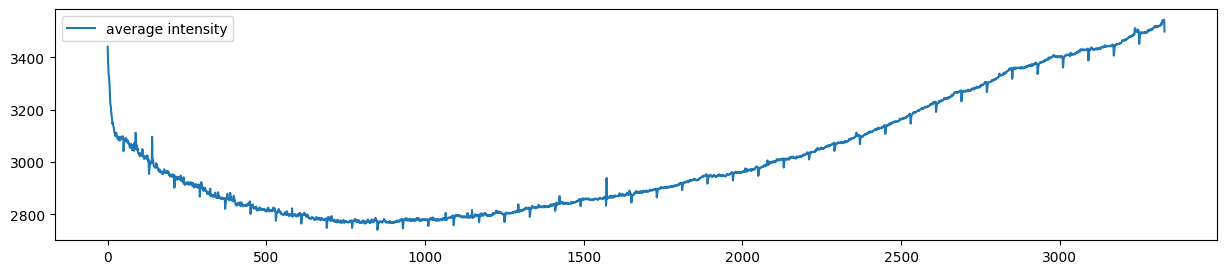

In [25]:
# get average intensity
avg = np.mean(X, axis=(1,2))  # average intensity across all cells
plt.figure(figsize=(15, 3))
plt.plot([t for t in range(len(avg))], avg, label='average intensity')
plt.legend()

selected = list(d.keys())

# set all values in Y to 0 except for selected cells
Y_selected = np.zeros(Y.shape)
for i in selected:
    Y_selected[Y.astype(np.uint16)==i] = i
viewer.add_labels(Y_selected.astype(np.uint16), name='selected')

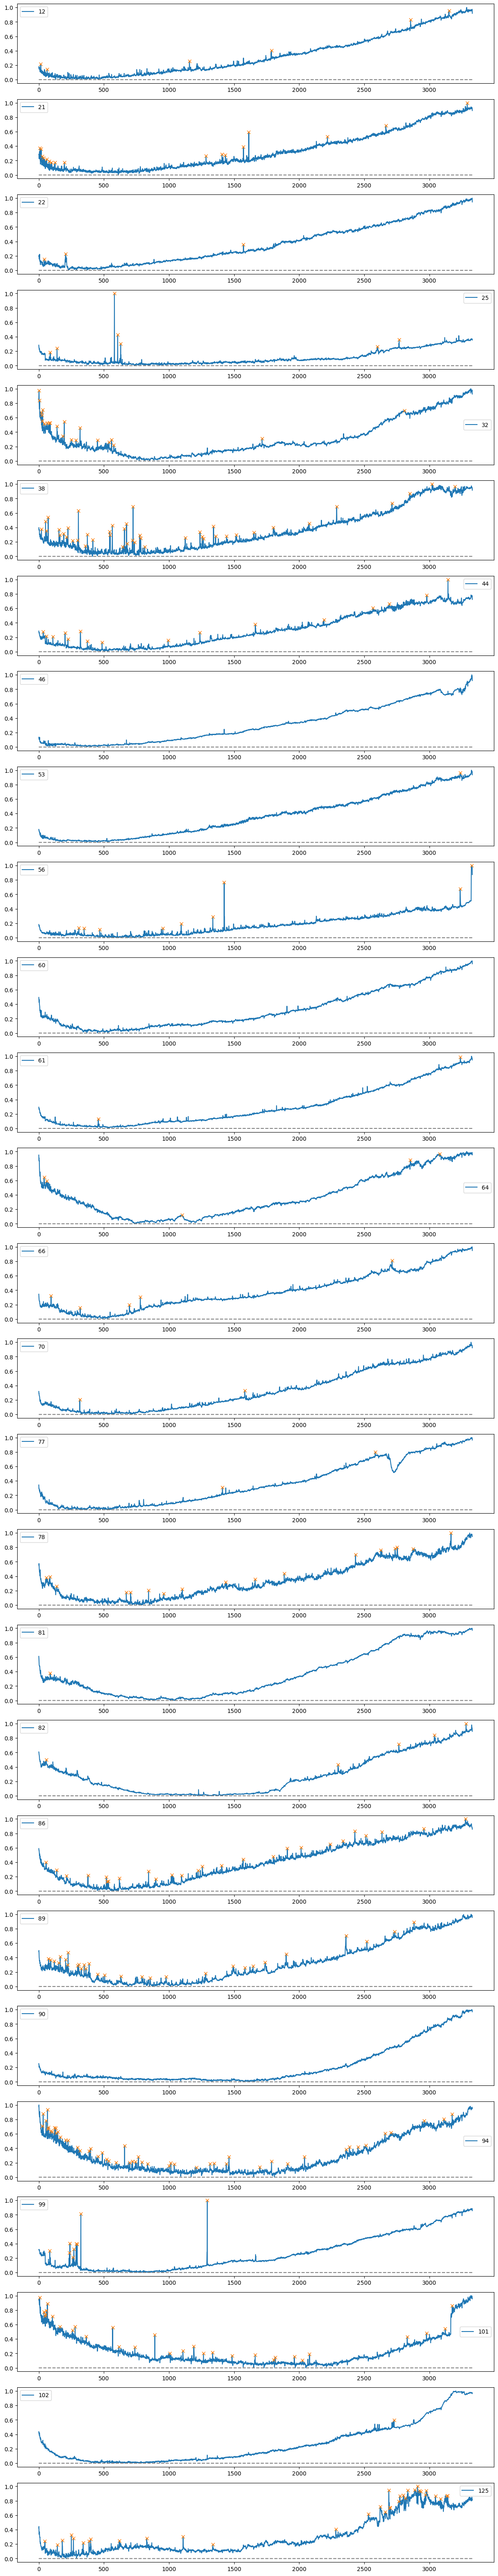

In [40]:
# plot intensities
def replace_nan_with_zero(d):
    for label in d.keys():
        d[label]['intensities'] = np.nan_to_num(d[label]['intensities'])
    return d

def peak_finding(x, distance = 3, prominence = 0.1):# threshold=0.01):#
    peaks, _ = find_peaks(x, distance=distance, prominence=prominence)# threshold=threshold)#
    return peaks

def plot_intensity(d, selected=None):
    if selected is None:
        labels = d.keys()
    else:
        labels = selected
    fig, axs = plt.subplots(len(labels), 1, figsize=(15,len(labels)*3))

    for i, label in enumerate(labels):
        try:
            y = d[label]['intensities'][start_point:]

            # sliding window
            window_size = 100
            sliding_size = 10
            for window in range(0, len(y), sliding_size):
                crop = [window, window+window_size]
                y_crop = y[crop[0]:crop[1]]

            avg_crop= avg[crop[0]:crop[1]]
            # divide by mean intensity of window
            #y = y - avg_crop
            # normalize y to 0-1
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
            y = y
            x = [t for t in range(len(y))]
            
            axs[i].plot(x, y, label=str(label))  # Add label to the plot
            axs[i].legend()  # Add legend to the subplot

            # find peaks
            peaks = peak_finding(y)
            axs[i].plot(peaks, y[peaks], "x")
            axs[i].plot(np.zeros_like(y), "--", color="gray")

        except KeyError:
            print('Label ' + str(label) + ' does not exist within timeframe.')

    plt.show()

plot_intensity(replace_nan_with_zero(d))#, selected=selected)

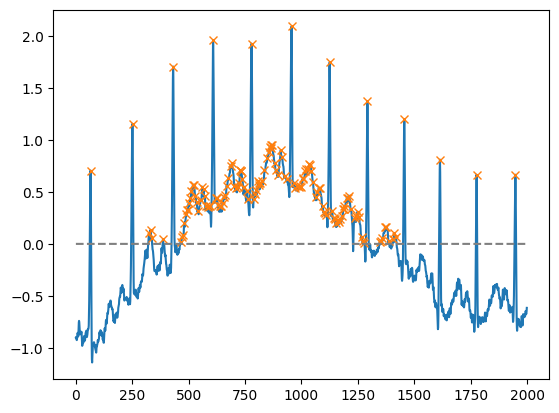

In [15]:
# scipy signal find peaks
from scipy.signal import find_peaks
from scipy.datasets import electrocardiogram
def peaks(x):
    peaks, _ = find_peaks(x, height=0)
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()

def plot_intensity(d, selected=None):
    if selected is None:
        labels = d.keys()
    else:
        labels = selected
    avg = np.array([d[i]['intensities'] for i in labels])
    avg = np.mean(avg, axis=0)  # average intensity across all cells

    fig, axs = plt.subplots(len(labels), 1, figsize=(15,len(labels)*3))

    for i, label in enumerate(labels):
        try:
            y = d[label]['intensities']
            # subtract by average intensity
            y = y - avg

            x = [t for t in range(len(y))]
            
            axs[i].plot(x, y, label=str(label))  # Add label to the plot
            axs[i].legend()  # Add legend to the subplot
        except KeyError:
            print('Label ' + str(label) + ' does not exist within timeframe.')

    plt.show()


x = electrocardiogram()[2000:4000]
peaks(x)